# Stock Screener

### This notebook is intended to help get a centralized view of important statistics for stocks of companies.

### 1. Imports
We begin with all the imports we will need for analysis.

In [43]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
import math
import json

### 2. Getting tickers for gold stocks.

In [44]:
#Where tickers comes from
goldStocksUrl = "http://www.miningfeeds.com/gold-mining-report-all-countries"

def goldStockParser(url, tickerColumn, stockTypes):
    """Goes to url above and pulls the tickers of each 
       gold mining company, dumps them in a pickle file 
       and returns the tickers as a list."""
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "lxml")
    table = soup.find("table")
    tickers = []
    for row in table.findAll("tr")[1:]:
        ticker = row.findAll("td")[tickerColumn].text
        #Randgold real ticker.
        if (ticker == "GOLD.L"):
            ticker = "GOLD"
        tickers.append(ticker)

    with open(stockTypes + ".pickle", "wb") as file:
        pickle.dump(tickers, file)

    return tickers

def pickleLoader(stockTypes):
    """Loads tickers from a pickle file and returns them as a list."""
    with open(stockTypes + ".pickle", "rb") as file:
        return pickle.load(file)

#Look in cache if False, go to website if true.    
reloadGoldTickers = True

badDataStocks = ["GLF.AX", "AZ.TO", "LEX.TO", "RN.TO", "P.TO", "CSQ.V",
                 "DNA.TO", "PRH.AX", "GBU.TO", "RPM.V", "ARZ.TO", "ABU.AX",
                 "BAA.TO",]
goldStockTickers = []

if reloadGoldTickers:
    goldStockTickers = goldStockParser(goldStocksUrl, 2, "goldStocks")
else:
    goldStockTickers = pickleLoader("goldStocks")

#Remove stocks with bad data.    
for ticker in badDataStocks:
    goldStockTickers.remove(ticker)
    
print(goldStockTickers)

ValueError: list.remove(x): x not in list

### 3. Specify formatting details of data.

Specify rows of data that are wanted from yahoo.

Specify rows of data that have letters in their numbers for conversion.

Specify rows of data that have percentage signs in their numbers for conversion.

In [45]:
wantedRows = {0  : "marketCap", 
              1  : "enterpriseValue",
              2  : "trailingPe",
              3  : "forwardPe",
              4  : "5YrPeg",
              5  : "priceSales",
              6  : "priceBook",
              7  : "evSales",
              8  : "evEBITDA",
              11 : "profitMargin",
              12 : "operatingMargin",
              13 : "returnOnAssets",
              14 : "returnOnEquity",
              15 : "revenue",
              16 : "revenuePerShare",
              17 : "quarterlyRevenueGrowth",
              18 : "grossProfit",
              19 : "EBITDA",
              20 : "netIncomeForCommon",
              21 : "Diluted EPS",
              22 : "quarterlyEarningsGrowth",
              23 : "totalCash",
              24 : "cashPerShare",
              25 : "totalDebt",
              26 : "debtEquity",
              27 : "currentRatio",
              28 : "bookValuePerShare", 
              29 : "operatingCashFlow",
              30 : "leveredFreeCashFlow",
              31 : "beta3YrMonthly",
              32 : "52WeekChange",
              33 : "spy52WeekChange",
              34 : "52WeekHigh",
              35 : "52WeekLow",
              36 : "50dayMvAvg",
              37 : "200dayMvAvg",
              38 : "avg3MonthVol",
              39 : "avg10DayVol",
              40 : "sharesOutstanding",
              41 : "sharesFloating",
              42 : "heldByInsiders",
              43 : "heldByInstitutions",
              44 : "sharesShort1MonthPrior",
              45 : "shortRatio",
              46 : "shortToFloat",
              47 : "shortToOutstanding",
              48 : "sharesShort2MonthsPrior",
              49 : "forwardDividendRate",
              50 : "forwardDividendYield",
              51 : "trailingDividendRate",
              52 : "trailingDividendYield",
              53 : "5yrAvgDividendYield",
              54 : "payoutRatio",
              55 : "dividendDate",
              56 : "exDividendDate",
              57 : "lastSplitFactorNewPerOld",
              58 : "lastSplitDate",
              60 : "currentPrice",}

letterNumbers = ["marketCap", 
                 "enterpriseValue",
                 "revenue",
                 "grossProfit",
                 "EBITDA",
                 "netIncomeForCommon",
                 "totalCash",
                 "totalDebt",
                 "operatingCashFlow",
                 "leveredFreeCashFlow",
                 "avg3MonthVol",
                 "avg10DayVol",
                 "sharesOutstanding",
                 "sharesFloating",
                 "sharesShort1MonthPrior",
                 "sharesShort2MonthsPrior",]

percentageNumbers = ["profitMargin",
                     "operatingMargin",
                     "returnOnAssets",
                     "returnOnEquity",
                     "quarterlyRevenueGrowth",
                     "quarterlyEarningsGrowth",
                     "52WeekChange",
                     "spy52WeekChange",
                     "heldByInsiders",
                     "heldByInstitutions",
                     "shortToFloat",
                     "shortToOutstanding",
                     "forwardDividendYield",
                     "trailingDividendYield",
                     "payoutRatio",]


### 4. Retreive data from yahoo and cache it.
We need to look up data from yahoo and store it in a csv locally for caching purposes. Also want to format well. ie remove redundant columns and rename.

In [46]:
baseurl = "https://uk.finance.yahoo.com/quote/"

def getDataFromYahoo(stockTypes, tickers, baseurl = baseurl):
    """Checks if data has been stored in csv, if not
       looks to yahoo. Then returns as map of tickers to dataframe."""
    #Create directory for data of tickers.
    dataDir = "./%s_data" % stockTypes
    createDirIfItDoesntExist(dataDir)
    
    frames = {}
    
    for ticker in tickers:
        dataFile = "./%s/%s.csv" % (dataDir, ticker)
        data = None
        if not os.path.exists(dataFile):
            exists, data = saveDataAndReturnSeries(dataFile, ticker)
            if not exists:
                continue
        else:
            print("Already have %s" % ticker)
            data = pd.Series.from_csv(dataFile, index_col=0)
        frames[ticker] = data
    return pd.DataFrame(frames)

def createDirIfItDoesntExist(dataDir):
    """If directory with name dataDir does not exist, create it."""
    if not os.path.exists(dataDir):
        os.makedirs(dataDir)
        
def reformatData(data):
    """Reformat data with better names and remove redundancies"""
    dataDict = {}
    for index in wantedRows:
        series = data.loc[index]
        key = wantedRows[index]
        value = series.get(1)
        dataDict[key] = value
    return pd.Series(dataDict)

def getCurrency(html):
    """Gets the string of the currency stock is priced in."""
    soup = bs(html)
    results = soup.findAll("span", {"data-reactid" : "9"})
    i = 0
    line = None
    for result in results:
        if i == 1:
            line = result.text
        i += 1
    if line == None:
        return False, None
    return True, line[-3:] 
        
def saveDataAndReturnSeries(dataFile, ticker):
    """Gets data from yahoo and dumps in csv file before 
       returning data as pandas series. Returns true, series if
       there is data, false, none if not."""
    print("Requesting: %s" % ticker)

    #Go to summary page and scrape open.
    priceData = requests.get(baseurl + "%s?p=%s" % (ticker, ticker))       
    summaryFrames = pd.read_html(priceData.text)
    summaryFrame = pd.concat(summaryFrames, ignore_index=True)
    priceFrame = summaryFrame.loc[1:1]
    
    #Scrape currency from summary page.
    exists, currency = getCurrency(priceData.text)
    if not exists:
        print("Broken Ticker %s", ticker)
        return False, None
    
    #Go to stats page and scrape stats.
    data = requests.get(baseurl + "%s/key-statistics?p=%s" % (ticker, ticker))
    frames = pd.read_html(data.text)
    if len(frames) < 3:
        print("No data for: %s" % ticker)
        return False , None

    #Join stats and price
    frames.append(priceFrame)
    frame = pd.concat(frames, ignore_index=True)

    #Reformat
    reformattedSeries = reformatData(frame)
    reformattedSeries["currency"] = currency.upper()
    
    #Save data
    reformattedSeries.to_csv(dataFile)
    return True, reformattedSeries

# 5. Specify company tickers to analyse. Specify weighting of importance of metrics. (Only place needed to edit for basic analysis.)

Weights must sum to 1.

tickerData is the dataframe.

String passed to getDataFromYahoo is the name of the folder where data will be cached.

Second argument to getDataFromYahoo is the list of tickers to analyse.

In [47]:
#Gold Stocks
goldStockTickers = ['NEM', 'ABX', 'FNV.TO', 'NCM.AX', 'GG', 'AEM', 'KGC', 'RGLD', 'RRS.L', 'FRES.L', 'AGG.AX', 'EVN.AX', 'GFI', 'BTO.TO', 'YRI.TO', 'IMG.TO', 'AGI.TO', 'CEY.L', 'PVG', 'DGC.TO', 'NGD.TO', 'RRL.AX', 'OGC.TO', 'SBM.AX', 'CG.TO', 'EDV.TO', 'NG.TO', 'ELD.TO', 'SAR.AX', 'SMF.TO', 'HMY', 'TXG.TO', 'CGG.TO', 'NSU.TO', 'GUY.TO', 'RSG.AX', 'SEA.TO', 'MUX', 'RIC', 'PG.TO', 'OSK.TO', 'ALIAF', 'CNL.TO', 'GOR.AX', 'POG.L', 'GSS', 'PAF.L', 'AR.TO', 'PRU.AX', 'TBR.AX', 'BGM.V', 'TGZ.TO', 'SBB.TO', 'GORO', 'WDO.TO', 'HRT.TO', 'WAF.AX', 'VIT.V', 'AOT.V', 'NGQ.TO', 'BDR.AX', 'HUM.L', 'RMS.AX', 'SLR.AX', 'BSX.TO', 'GCY.AX', 'KOR.TO', 'MOZ.TO', 'BTR.V', 'HRR.AX', 'PRB.V', 'ALK.AX', 'HAS.AX', 'R.TO', 'JAG.TO', 'MAX.TO', 'TNG.AX', 'PEN.AX', 'CAL.TO', 'TLG.AX', 'RUP.V', 'GGP.L', 'AAL.V', 'KCN.AX', 'ITH.TO', 'MML.AX', 'GGG.AX', 'VGZ', 'ARU.V', 'RMX.TO', 'QBL.AX', 'TSG.L', 'ATC.V', 'KGL.AX', 'TML.TO', 'IMA.AX', 'DRM.AX', 'RED.AX', 'MTO.V', 'DGR.AX', 'MRC.AX', 'DNG.TO', 'LIO.V', 'GME.AX', 'LEG.AX', 'BAR.TO', 'ATM.V', 'EAR.AX', 'KRM.AX', 'FML.AX', 'ORN.AX', 'ER.TO', 'RGD.V', 'RBX.V', 'LYD.TO', 'TXR.V', 'DEG.AX', 'TAM.AX', 'NGY.AX', 'CHN.AX', 'GRR.V', 'LG.V', 'GSR.V', 'TRY.AX', 'TNX.TO', 'TLM.AX', 'ME.TO', 'MJS.V', 'GCM.TO', 'BSR.AX', 'RTG.TO', 'CAY.AX', 'KTN.V', 'MRP.AX', 'ARE.AX', 'FSY.TO', 'TON.AX', 'SRB.L', 'BCN.AX', 'TSG.V', 'MAT.AX', 'IRC.AX', 'ERM.AX', 'ORV.TO', 'HMX.V', 'NGE.V', 'SPA.V', 'MAW.TO', 'MNR.TO', 'ANX.TO', 'SKE.V', 'AAU.L', 'WHY.V', 'NAG.AX', 'GRG.V', 'GQC.V', 'AAR.AX', 'AGC.V', 'HAW.AX', 'RUG.V', 'ECR.V', 'SIH.AX', 'SMC.AX', 'GLN.AX', 'GQM.TO', 'GDP.L', 'SAU.TO', 'MMV.V', 'GAL.V', 'MMY.V', 'CAS.AX', 'LPK.V', 'GWR.AX', 'REX.V', 'CLH.V', 'KG.V', 'AAB.TO', 'IAU.AX', 'AGG.V', 'BAR.AX', 'DRA.AX', 'OGR.V', 'AGD.V', 'DGO.AX', 'WDG.V', 'WKM.V', 'ANK.V', 'AZX.V', 'RRI.V', 'GWA.V', 'MC.V', 'BRZ.V', 'JPR.AX', 'CRB.AX', 'SWA.V', 'PJX.V', 'OOO.V', 'AZM.AX', 'AOM.AX', 'RDS.V', 'MUN.V', 'MDI.AX', 'MAE.V', 'TEN.V', 'HLX.AX', 'AGS.AX', 'LME.V', 'CTM.AX', 'RPX.V', 'MSR.AX', 'BAT.V', 'CTO.AX', 'MTU.V', 'RG.V', 'ECC.V', 'IO.V', 'GGA.TO']

# S&P 500
spy = ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'AYI', 'ADBE', 'AAP', 'AMD', 'AES', 'AMG', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN', 'ALGN', 'ALLE', 'AGN', 'ADS', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'ANSS', 'ANTM', 'AON', 'APA', 'AIV', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ARNC', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BHGE', 'BLL', 'BAC', 'BAX', 'BBT', 'BDX', 'BRK.B', 'BBY', 'BIIB', 'BLK', 'HRB', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BHF', 'BMY', 'AVGO', 'BF.B', 'CHRW', 'CA', 'COG', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'CBS', 'CELG', 'CNC', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'CXO', 'COP', 'ED', 'STZ', 'GLW', 'COST', 'COTY', 'CCI', 'CSRA', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DLR', 'DFS', 'DISCA', 'DISCK', 'DISH', 'DG', 'DLTR', 'D', 'DOV', 'DWDP', 'DPS', 'DTE', 'DUK', 'DRE', 'DXC', 'ETFC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMR', 'ETR', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'RE', 'ES', 'EXC', 'EXPE', 'EXPD', 'ESRX', 'EXR', 'XOM', 'FFIV', 'FB', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FE', 'FISV', 'FLIR', 'FLS', 'FLR', 'FMC', 'FL', 'F', 'FTV', 'FBHS', 'BEN', 'FCX', 'GPS', 'GRMN', 'IT', 'GD', 'GE', 'GGP', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GS', 'GT', 'GWW', 'HAL', 'HBI', 'HOG', 'HRS', 'HIG', 'HAS', 'HCA', 'HCP', 'HP', 'HSIC', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HPQ', 'HUM', 'HBAN', 'HII', 'IDXX', 'INFO', 'ITW', 'ILMN', 'INCY', 'IR', 'INTC', 'ICE', 'IBM', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IPGP', 'IQV', 'IRM', 'JBHT', 'JEC', 'SJM', 'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KMB', 'KIM', 'KMI', 'KLAC', 'KSS', 'KHC', 'KR', 'LB', 'LLL', 'LH', 'LRCX', 'LEG', 'LEN', 'LUK', 'LLY', 'LNC', 'LKQ', 'LMT', 'L', 'LOW', 'LYB', 'MTB', 'MAC', 'M', 'MRO', 'MPC', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MAT', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'KORS', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 'TAP', 'MDLZ', 'MON', 'MNST', 'MCO', 'MS', 'MSI', 'MYL', 'NDAQ', 'NOV', 'NAVI', 'NKTR', 'NTAP', 'NFLX', 'NWL', 'NFX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NBL', 'JWN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'PCAR', 'PKG', 'PH', 'PAYX', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'RL', 'PPG', 'PPL', 'PX', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'QCOM', 'PWR', 'RRC', 'RJF', 'RTN', 'O', 'RHT', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SCG', 'SLB', 'STX', 'SEE', 'SRE', 'SHW', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'SRCL', 'SYK', 'STI', 'SIVB', 'SYMC', 'SYF', 'SNPS', 'SYY', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'FTI', 'TXN', 'TXT', 'BK', 'CLX', 'COO', 'HSY', 'MOS', 'TRV', 'DIS', 'TMO', 'TIF', 'TJX', 'TMK', 'TSS', 'TSCO', 'TDG', 'TRIP', 'FOXA', 'FOX', 'TSN', 'USB', 'UDR', 'ULTA', 'UAA', 'UA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX','XYL', 'YUM', 'ZBH', 'ZION', 'ZTS',]

# Edit this for different analysis.
tickerData = getDataFromYahoo("gold_stocks", goldStockTickers)

# Convert Nan values to 0.
tickerData[pd.isnull(tickerData)] = "0"
print(tickerData.head())

# Weights of importance
weights = {
    "priceBook" : 0.3,
    "trailingPe" : 0.3,
    "dividendYieldDiff" : 0.05,
    "debtEquity" : 0.3,
    "returnOnEquity": 0.05,
}

# Specify if a higher number or lower number is better, 0 lower, 1 higher.
ordering = {
    "priceBook" : 0,
    "trailingPe" : 0,
    "dividendYieldDiff" : 1,
    "debtEquity" : 0,
    "returnOnEquity": 1,
}

Already have NEM
Requesting: ABX
Broken Ticker %s ABX
Already have FNV.TO
Already have NCM.AX
Already have GG
Already have AEM
Already have KGC
Already have RGLD
Requesting: RRS.L
Broken Ticker %s RRS.L
Already have FRES.L
Already have AGG.AX
Already have EVN.AX
Already have GFI
Already have BTO.TO
Already have YRI.TO
Already have IMG.TO
Already have AGI.TO
Already have CEY.L
Already have PVG
Already have DGC.TO
Already have NGD.TO
Already have RRL.AX
Already have OGC.TO
Already have SBM.AX
Already have CG.TO
Already have EDV.TO
Already have NG.TO
Already have ELD.TO
Already have SAR.AX
Already have SMF.TO
Already have HMY
Already have TXG.TO
Already have CGG.TO
Already have NSU.TO
Already have GUY.TO
Already have RSG.AX
Already have SEA.TO
Already have MUX
Already have RIC
Already have PG.TO
Already have OSK.TO
Already have ALIAF
Already have CNL.TO
Already have GOR.AX
Already have POG.L
Already have GSS
Already have PAF.L
Already have AR.TO
Already have PRU.AX
Already have TBR.AX
Alr

### 6. Reformat text rows into numbers for numerical analysis.

Use maps defined earlier to create masks and apply conversion functions.

In [48]:
def convertLetter(string):
    if string == "0":
        return 0
    string = string.replace(",", "")
    number = string[0:-1]
    letter = string[-1]
    if letter == "B":
        return float(number) * 1000
    if letter == "M":
        return float(number) 
    if letter == "k":
        return float(number) / 100
    
def convertPercent(string):
    if string == "∞%":
        return np.inf
    if string == "0":
        return 0
    string = string.replace(",", "")
    number = string[0:-1]
    return float(number)

# Create mask for letter numbers and convert them.
letterMask = tickerData.index.isin(letterNumbers)
tickerData[letterMask] = tickerData[letterMask].applymap(convertLetter)

# Create mask for percentage numbers and convert them.
percentageMask = tickerData.index.isin(percentageNumbers)
tickerData[percentageMask] = tickerData[percentageMask].applymap(convertPercent)

print(tickerData.head())

                   NEM  FNV.TO NCM.AX    GG    AEM    KGC   RGLD FRES.L  \
marketCap        24860   17760  18900  9250   9640   3880   5330   5510   
enterpriseValue  26610   17900  19920     0  11180   5240   5510   5830   
trailingPe       68.22  127.08  55.62     0      0      0  56.55  15.75   
forwardPe        20.84   62.45      0     0  39.87  20.47  38.00      0   
5YrPeg            1.56    8.02      0     0   1.85   1.62   4.25      0   

                AGG.AX EVN.AX  ... CTM.AX  RPX.V MSR.AX BAT.V CTO.AX MTU.V  \
marketCap         6870   5210  ...  16.23  16.62  10.57  6.34   10.8  5.67   
enterpriseValue   3110   5240  ...  12.43  13.51   1.74 -1.85  10.98  4.76   
trailingPe       10.28  22.57  ...      0      0      0     0      0     0   
forwardPe            0      0  ...      0      0      0     0      0     0   
5YrPeg               0      0  ...      0      0      0     0      0     0   

                 RG.V   ECC.V   IO.V GGA.TO  
marketCap        8.93    7.68  11.

### 7. Now normalize for currencies.

Companies stock is denominated in different currencies, we must normalise for good aggregations.

Use api to look up fx rates.

In [49]:
fxurl = "http://data.fixer.io/api/latest?access_key=d76b170eea08be26f92b73f07d9a7cad&symbols=USD,AUD,CAD,GBP,EUR"
r = requests.get(fxurl)
r = json.loads(r.text)
rates = r["rates"]
usdFactor = rates["USD"]
for c in rates:
    rates[c] = 1 / (rates[c] / usdFactor)
print(rates)    

{'USD': 1.0, 'AUD': 0.6983557623255378, 'CAD': 0.7430555647839427, 'GBP': 1.316093164697589, 'EUR': 1.118312}


Now we must specify which companies, ie columns, are not denominated in dollars.

In [50]:
nonDollarDenominated = (tickerData.loc["currency"] != "USD").values

Now we specify which rows need to be converted.

In [51]:
currencyConcerned = ["marketCap", 
                     "enterpriseValue",
                     "revenue",
                     "grossProfit",
                     "EBITDA",
                     "netIncomeForCommon",
                     "totalCash",
                     "totalDebt",
                     "operatingCashFlow",
                     "leveredFreeCashFlow",
                     "52WeekHigh",
                     "52WeekLow",
                     "50dayMvAvg",
                     "200dayMvAvg",]


def convertCurrency(amount, factor):
    return round(float(amount) * factor, 2)

currencyMask = tickerData.index.isin(currencyConcerned)
nonDollarData = tickerData[currencyMask].loc[: ,nonDollarDenominated]


for ticker in nonDollarData:
    factor = rates[tickerData.loc["currency", ticker]]
    nonDollarData[ticker] = nonDollarData.loc[:, ticker].apply(convertCurrency, args=(factor, ))
    
tickerData.loc[currencyConcerned, nonDollarDenominated] = nonDollarData

#Make zeros nan.
tickerData = tickerData.replace("0", np.NaN)
tickerData = tickerData.replace(0, np.NaN)
print(tickerData.head())  

                   NEM   FNV.TO   NCM.AX    GG    AEM    KGC   RGLD   FRES.L  \
marketCap        24860  13196.7  13198.9  9250   9640   3880   5330  7251.67   
enterpriseValue  26610  13300.7  13911.2   NaN  11180   5240   5510  7672.82   
trailingPe       68.22   127.08    55.62   NaN    NaN    NaN  56.55    15.75   
forwardPe        20.84    62.45      NaN   NaN  39.87  20.47  38.00      NaN   
5YrPeg            1.56     8.02      NaN   NaN   1.85   1.62   4.25      NaN   

                  AGG.AX   EVN.AX  ... CTM.AX  RPX.V MSR.AX BAT.V CTO.AX  \
marketCap         4797.7  3638.43  ...  11.33  12.35   7.38  4.71   7.54   
enterpriseValue  2171.89  3659.38  ...   8.68  10.04   1.22 -1.37   7.67   
trailingPe         10.28    22.57  ...    NaN    NaN    NaN   NaN    NaN   
forwardPe            NaN      NaN  ...    NaN    NaN    NaN   NaN    NaN   
5YrPeg               NaN      NaN  ...    NaN    NaN    NaN   NaN    NaN   

                MTU.V  RG.V ECC.V   IO.V GGA.TO  
marketCap   

### 8. Transpose dataframe for easy access to each type of data.

In [52]:
tickerData = tickerData.transpose()
print(tickerData.head())

       marketCap enterpriseValue trailingPe forwardPe 5YrPeg priceSales  \
NEM        24860           26610      68.22     20.84   1.56       3.43   
FNV.TO   13196.7         13300.7     127.08     62.45   8.02      27.28   
NCM.AX   13198.9         13911.2      55.62       NaN    NaN       5.29   
GG          9250             NaN        NaN       NaN    NaN        NaN   
AEM         9640           11180        NaN     39.87   1.85       4.50   

       priceBook evSales evEBITDA profitMargin  ... trailingDividendRate  \
NEM         1.54    3.68     9.70         3.26  ...                 0.56   
FNV.TO      3.83   27.50    34.92        21.36  ...                 0.95   
NCM.AX      2.57    5.57    12.31         9.54  ...                 0.19   
GG           NaN     NaN      NaN          NaN  ...                 0.08   
AEM         2.11    5.21    14.97        -15.6  ...                 0.46   

       trailingDividendYield 5yrAvgDividendYield payoutRatio dividendDate  \
NEM            

### 9. Make every number a float.

In [53]:
def tryConvertToFloat(x):
    try:
        return float(x)
    except(ValueError, TypeError):
        return x

for column in tickerData:
    tickerData[column] = tickerData[column].map(tryConvertToFloat)
    
print(tickerData)    

        marketCap  enterpriseValue  trailingPe forwardPe  5YrPeg  priceSales  \
NEM      24860.00         26610.00       68.22     20.84    1.56        3.43   
FNV.TO   13196.67         13300.69      127.08     62.45    8.02       27.28   
NCM.AX   13198.92         13911.25       55.62       NaN     NaN        5.29   
GG        9250.00              NaN         NaN       NaN     NaN         NaN   
AEM       9640.00         11180.00         NaN     39.87    1.85        4.50   
KGC       3880.00          5240.00         NaN     20.47    1.62        1.21   
RGLD      5330.00          5510.00       56.55        38    4.25       12.69   
FRES.L    7251.67          7672.82       15.75       NaN     NaN        2.62   
AGG.AX    4797.70          2171.89       10.28       NaN     NaN        1.74   
EVN.AX    3638.43          3659.38       22.57       NaN     NaN        3.44   
GFI       3070.00          4870.00         NaN       NaN     NaN        1.19   
BTO.TO    2637.85          2942.50      

### 10. Filter by market cap.

Return companies above the some threshold.

In [54]:
tickerData = tickerData[tickerData["marketCap"] >= 800]

### 11. Create function to plot a metric of a company above a certain threshold.

In [55]:
def plotGraphOfMetricAboveAverage(metric, tickerData, threshold):
    """Takes string of metric that is to be plotted and tickerData frame.
       Plots data above threshold."""
    
    # Trim.
    s = tickerData[metric]
    mean = s.mean()
    trimmed = tickerData[metric].where(lambda m : m > threshold).dropna()
    
    if trimmed.size == 0:
        print("No companies above threshold.")
        return
    
    # Specify figure details.
    plt.figure(figsize=(27, 10))
    title = "%s of companies above threshold: %s." % (metric, threshold)
    plt.title(title, size = "30")
    plt.xlabel("Company Ticker.", size="30")
    plt.ylabel(metric, size="30")
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    # Plot metric.
    sns.barplot(trimmed.index, trimmed.values)
    plt.plot()

### 12. Look for companies whose dividend yield is higher than 5 year average.

Sign of undevaluation.

In [56]:
tickerData["dividendYieldDiff"] = tickerData["trailingDividendYield"] - tickerData["5yrAvgDividendYield"]
higherYields = tickerData[tickerData["dividendYieldDiff"] > 0]

### 13. Normalize for ranking.

In [57]:
normalizedTickerData = pd.DataFrame()
for col in tickerData:
    try:
        minimum = tickerData[col].min()
        maximum = tickerData[col].max()
        
        normalizedTickerData[col] = tickerData[col].apply(lambda x: (x - minimum) / (maximum - minimum))
    except:
        normalizedTickerData[col] = tickerData[col]     

### 14. Rank based on weights and ordering.

Give a score to each company based on the weights to each metric specified above.

In [58]:
for metric in ordering:
    if ordering[metric] == 0:
        # Lower is better, need to swap.
        normalizedTickerData[metric] = 1 - normalizedTickerData[metric]     

# Accumualte score based on metric weights.        
scoreSeries = pd.Series()
weightList = list(weights.keys())
initialMetric = weightList[0]
scoreSeries = normalizedTickerData[initialMetric] * weights[initialMetric]
nextSeries = pd.Series()
for i in range(1, len(weightList)):
    metric = weightList[i]
    nextSeries =  weights[metric] * normalizedTickerData[metric]
    scoreSeries = scoreSeries.add(nextSeries, fill_value=0)

tickerData["score"] = scoreSeries    
print(tickerData["score"])

NEM       0.730454
FNV.TO    0.734541
NCM.AX    0.743947
GG             NaN
AEM       0.482823
KGC       0.469354
RGLD      0.803527
FRES.L    0.519131
AGG.AX    0.626238
EVN.AX    0.885554
GFI       0.316866
BTO.TO    0.506440
YRI.TO    0.442448
IMG.TO    0.562488
AGI.TO    0.620423
CEY.L     0.484091
PVG       0.626430
DGC.TO    0.764176
RRL.AX    0.932279
OGC.TO    0.849771
SBM.AX    0.947056
CG.TO     0.881929
EDV.TO    0.322465
NG.TO     0.342826
SAR.AX    0.594228
SMF.TO    0.541252
HMY       0.510220
NSU.TO         NaN
ALIAF     0.441356
Name: score, dtype: float64


### 15. Plot graph of best scoring companies. 

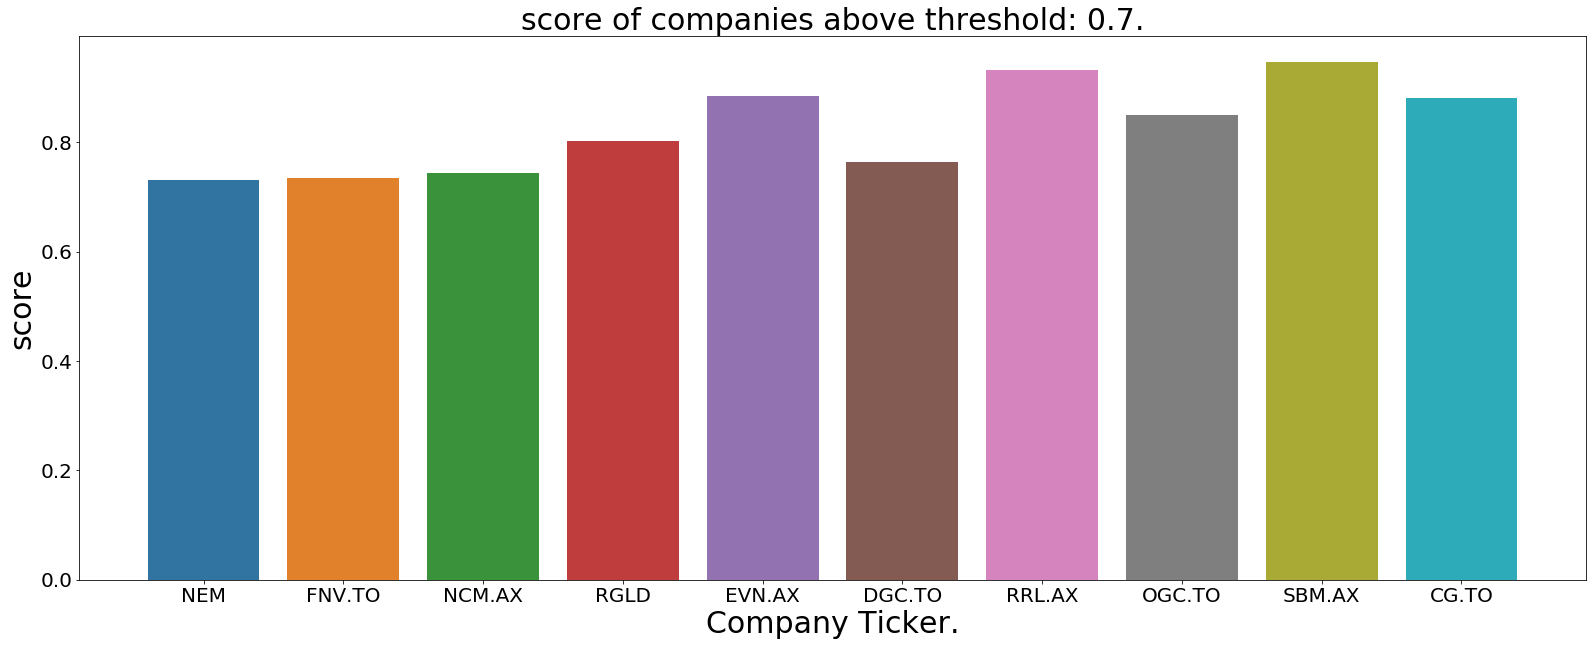

In [59]:
plotGraphOfMetricAboveAverage("score", tickerData, 0.7)

ValueError: cannot convert float NaN to integer

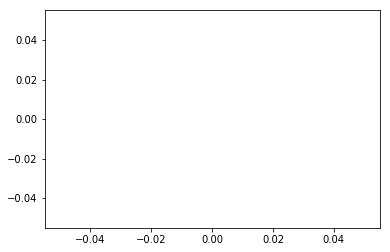

In [60]:
sns.distplot(tickerData["score"])
plt.show()